## Table of Contents

* [Imports](#Imports)
* [Feature Engineering](#Feature-Engineering)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Sentiment Analysis](#Sentiment-Analysis)
* [TF-IDF](#TF-IDF)
* [Pre-Processing](#Pre-Processing)
* [Topic Modeling](#Topic-Modeling)

### Imports

In [1]:
# ! pip install pyLDAvis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import scipy
import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

from gensim import matutils
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

#### Read In the Data

In [3]:
listing = pd.read_csv('./data/Chicago_Listings_Clean')
review = pd.read_csv('./data/Chicago_Reviews_Clean')

#### Allowing up to 100 columns to be previewed

In [4]:
pd.set_option("display.max_columns", 100)

# Feature Engineering

In [5]:
listing.head(3)

,id,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,bathrooms_text,bedrooms,amenities,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",Visiting The University of Chicago or attendin...,The apartment is less than one block from beau...,2008-08-29,My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,1.00,1.0,Hyde Park,41.78790,-87.58780,Private room in condominium,1,1 shared bath,1.0,"[""Free street parking"", ""Washer"", ""Fire exting...",$65.00,2,90,181,2015-01-09,2020-10-29,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,2.43
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,We have been closed for quite a while and will...,No Content,2008-12-29,Incredibly creative(Kathleen) and stunningly a...,within an hour,0.88,1.0,South Lawndale,41.85495,-87.69696,Entire apartment,7,1 bath,3.0,"[""Free street parking"", ""Garden or backyard"", ...",$117.00,2,60,395,2009-03-06,2020-07-14,96.0,10.0,9.0,10.0,10.0,10.0,9.0,t,2.71
2,7126,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",2009-05-19,We live in Chicago. We love to travel and see ...,within a few hours,0.93,2.0,West Town,41.90289,-87.68182,Entire apartment,2,1 bath,3.0,"[""Free street parking"", ""Smoke alarm"", ""Fire e...",$70.00,2,60,389,2009-07-03,2021-01-09,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,2.75


Binarize the values in the column.

In [6]:
listing['instant_bookable'] = listing['instant_bookable'].map({'f': 0, 't': 1})

Unpacking the list in the 'amenities' column and create dummy columns for each item in the amenities list.

In [7]:
listing['amenities'] = listing['amenities'].map(lambda x: ast.literal_eval(x))

listing = pd.concat([listing, pd.get_dummies(listing['amenities'].apply(pd.Series).stack()).sum(level=0)], axis=1)

In [8]:
listing.drop(columns = ['amenities'], inplace = True)

Creating new columns that provide the character length of the following columns: 'host_about', 'name', 'description', 'neighborhood_overview'.

In [9]:
listing['host_about_length'] = listing['host_about'].str.len()
listing['listing_name_length'] = listing['name'].str.len()
listing['description_length'] = listing['description'].str.len()
listing['neighborhood_overview_length'] = listing['neighborhood_overview'].str.len()

Creating new columns from the categorical values of other columns.

In [10]:
listing = pd.concat([listing, pd.get_dummies(listing['property_type'])], axis = 1)

In [11]:
listing = pd.concat([listing, pd.get_dummies(listing['bathrooms_text'])], axis = 1)

In [12]:
listing.drop(columns = ['property_type', 'bathrooms_text'], inplace = True)

Removing special characters from the price column and then converting from a 'string' to an 'int'.

In [13]:
listing['price'] = listing['price'].map(lambda x: x.lstrip('$'))

In [14]:
listing['price'] = listing['price'].map(lambda x: x.lstrip(','))

In [15]:
listing['price'].dtype

dtype('O')

In [16]:
listing['price'] = listing['price'].map(lambda x: x.split('.')[0])

In [17]:
listing['price'] = listing['price'].str.replace(',','').astype(int)

In [18]:
listing['price'].dtype

dtype('int64')

# Exploratory Data Analysis

In [19]:
listing.head(3)

,id,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,"120"" HDTV with Netflix, Amazon Prime Video, HBO Max","24"" HDTV with Amazon Prime Video, Netflix, Roku","25"" HDTV with Netflix","26"" HDTV with Amazon Prime Video","30"" HDTV with standard cable","32"" HDTV","32"" HDTV with HBO Max, premium cable","33"" HDTV with Netflix, Amazon Prime Video, Chromecast","40"" HDTV","40"" HDTV with Netflix","40"" TV with Roku","42"" HDTV","42"" HDTV with Netflix, Amazon Prime Video","42"" HDTV with Roku","42"" HDTV with premium cable","42"" HDTV with standard cable, premium cable","43"" HDTV with Netflix, HBO Max, Amazon Prime Video","50"" HDTV with Amazon Prime Video, HBO Max, Netflix","50"" HDTV with Amazon Prime Video, Netflix, Roku","50"" HDTV with Amazon Prime Video, Netflix, standard cable","50"" HDTV with Netflix, Amazon Prime Video",...,Private room in cottage,Private room in farm stay,Private room in guest suite,Private room in guesthouse,Private room in hostel,Private room in house,Private room in loft,Private room in serviced apartment,Private room in tiny house,Private room in townhouse,Room in aparthotel,Room in bed and breakfast,Room in boutique hotel,Room in hostel,Room in hotel,Room in serviced apartment,Shared room in apartment,Shared room in bungalow,Shared room in condominium,Shared room in hostel,Shared room in house,Tiny house,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,11 shared baths,11.5 shared baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3 shared baths,3.5 baths,4 baths,4 shared baths,4.5 baths,5 baths,5.5 baths,6.5 baths,7 baths,8 shared baths,8.5 baths,Half-bath,Private half-bath,Shared half-bath
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",Visiting The University of Chicago or attendin...,The apartment is less than one block from beau...,2008-08-29,My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,1.00,1.0,Hyde Park,41.78790,-87.58780,1,1.0,65,2,90,181,2015-01-09,2020-10-29,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,2.43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,We have been closed for quite a while and will...,No Content,2008-12-29,Incredibly creative(Kathleen) and stunningly a...,within an hour,0.88,1.0,South Lawndale,41.85495,-87.69696,7,3.0,117,2,60,395,2009-03-06,2020-07-14,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,2.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7126,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",2009-05-19,We live in Chicago. We love to travel and see ...,within a few hours,0.93,2.0,West Town,41.90289,-87.68182,2,3.0,70,2,60,389,2009-07-03,2021-01-09,93.0,10.0,9.0,10.0,10.0,10.0,10.0,0,2.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


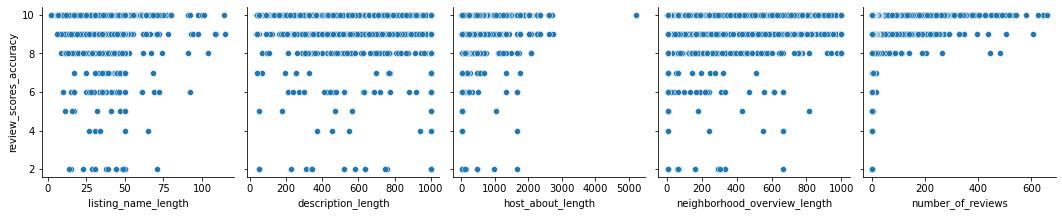

In [20]:
sns.pairplot(listing, 
             x_vars = ['listing_name_length', 'description_length', 'host_about_length', 'neighborhood_overview_length', 'number_of_reviews'], 
             y_vars = ['review_scores_accuracy'], 
             diag_kind = None, 
             height = 3);

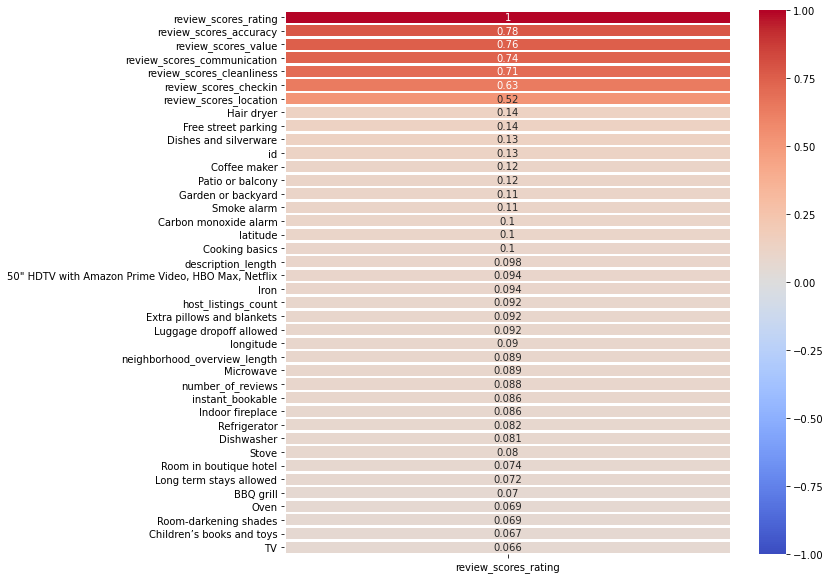

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing.corr()[['review_scores_rating']].abs().sort_values(by = ['review_scores_rating'], ascending = False)

sns.heatmap(corrs.head(40),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

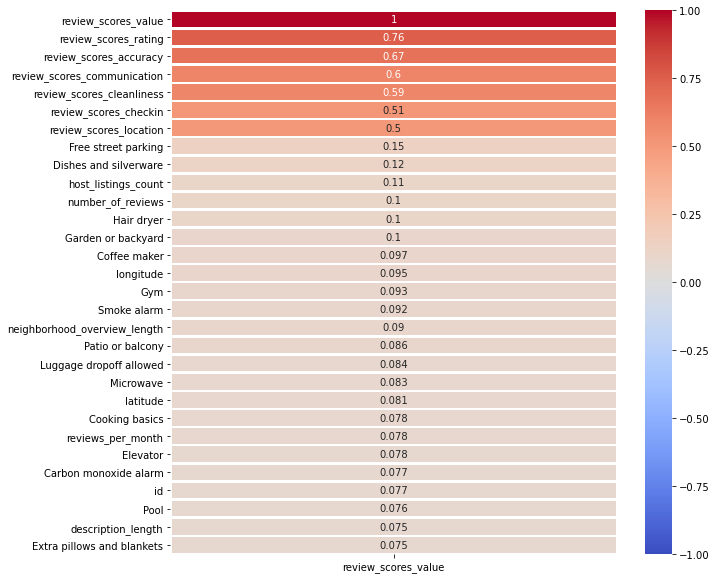

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing.corr()[['review_scores_value']].abs().sort_values(by = ['review_scores_value'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

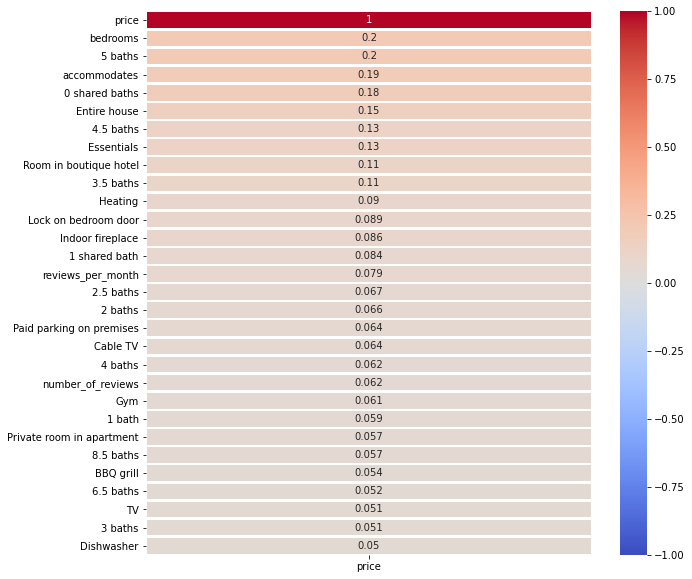

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing.corr()[['price']].abs().sort_values(by = ['price'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

## Sentiment Analysis

In [24]:
pd.options.display.max_colwidth = 200

In [25]:
corpus = list(review['comments']) 

In [26]:
sia = SentimentIntensityAnalyzer()

In [27]:
sentiment = []    

for comment in corpus:
    scores = sia.polarity_scores(comment)
    scores['comment'] = comment
    sentiment.append(scores)

reviews = pd.DataFrame(sentiment)
reviews.head()

,neg,neu,pos,compound,comment
0,0.000,0.433,0.567,0.9201,"Super location if you are visiting UChicago. Clean, comfortable, friendly, with lots of extras."
1,0.041,0.750,0.209,0.8339,"If I could have given Rebecca, stars, I would have! She made my first AirBNB experience one that I will not forget. Rebecca truly does have the gift of genuine, down to earth, hospitality. Tha..."
2,0.000,0.598,0.402,0.9847,"Rebecca's place is a joy! Stunningly beautiful and tasteful -- you will stay in the most comfortable guest room -- it is an ideal place to stay for a visit to the University of Chicago, which is o..."
3,0.000,0.537,0.463,0.9583,"Rebecca is a wonderful, thoughtful, and kind host. Good communication and very comfortable apartment space. I highly recommend staying at Rebecca's if you're visiting UChicago and/or the Hyde Park..."
4,0.000,0.531,0.469,0.9432,Very clean and convenient for the University. Rebecca was a lovely host who made a great effort to provide a great place to stay.


In [28]:
reviews['id'] = review['listing_id']

In [29]:
reviews.sort_values(by = 'pos', ascending = False).head(10)

,neg,neu,pos,compound,comment,id
33056,0.0,0.059,0.941,0.9421,"Great location, pretty clean. Good value!!",24672882
34833,0.0,0.070,0.930,0.9237,"Very comfortable & clean, great value",25213814
56828,0.0,0.071,0.929,0.9186,"Amazing spaces, clean & great value.",35846336
36237,0.0,0.073,0.927,0.9134,"Great, great value. Highly recommended.",25861262
51487,0.0,0.108,0.892,0.9477,"Fantastic apartment, huge, great value, great neighbourhood",32712634
36679,0.0,0.108,0.892,0.8074,Definitely a winner and a bargain.,25973971
33055,0.0,0.109,0.891,0.9359,"Good value, comfortable, clean and good location, recommended!",24672882
1330,0.0,0.110,0.890,0.9451,"Amazing space, great energy, super cool hosts.",1356190
28304,0.0,0.113,0.887,0.9491,Awesome stay! Super clean! Great location!,22325114
10364,0.0,0.114,0.886,0.9477,"Wonderful. Great location, beautiful space. Lovely.",11525186


In [30]:
reviews.sort_values(by = 'neg', ascending = False).head(10)

,neg,neu,pos,compound,comment,id
33413,0.570,0.430,0.000,-0.6489,I wouldn't recommend because very dirty places,24783093
24141,0.551,0.449,0.000,-0.5994,"It was a decent location, no complaints.",20517017
24201,0.551,0.449,0.000,-0.5994,"Place was as described, no complaints.",20524028
37738,0.550,0.450,0.000,-0.5968,Not good location. Not very clean,26393404
44005,0.498,0.502,0.000,-0.7146,"Lots of people, very confused and poor service",29093342
17427,0.481,0.373,0.146,-0.6694,"Good price, but not comfortable and not clean.",16781530
34491,0.464,0.536,0.000,-0.6360,I was there for a night and I have no complaints!,25185506
42675,0.456,0.397,0.147,-0.5980,Apartment clean but very noisy. Sleep was difficult.,28545309
8251,0.450,0.550,0.000,-0.5994,No complaints. Prompt with responding and very accommodating.,8824905
44919,0.447,0.553,0.000,-0.8060,"Near home, it's not a safe place for traveler. It's so dangerous!!!",29371939


In [31]:
reviews.sort_values(by = 'pos', ascending = True).head(10)

,neg,neu,pos,compound,comment,id
26700,0.109,0.891,0.0,-0.2960,"Stylish room in a decent location. Taller guests watch your head, the ceiling is a little short in the lower units.",21553179
8627,0.000,1.000,0.0,0.0000,Within walking distance to Wrigley Field.,9078918
2098,0.277,0.723,0.0,-0.5574,I would not suggest for anyone to come here. It was an awkward and awful.,2305230
43939,0.150,0.850,0.0,-0.5583,There are no stores within walking distance and the area doesn't feel safe at night. The only bed is really small (double) and squeaks every time you move.,29031690
27179,0.000,1.000,0.0,0.0000,Stylish space and close to everything we needed!,21748100
8645,0.000,1.000,0.0,0.0000,Quick responses and lots of sleeping space!,9078918
36304,0.000,1.000,0.0,0.0000,She be all over your business,25891309
15652,0.077,0.923,0.0,-0.1695,This place is so untidy and there is so much of owners stuff in the house. It's not worth the money.,15566486
56561,0.043,0.957,0.0,-0.1786,"The location could not be better. it is in the middle of the center and close to all the shops. The bed is incredible, you really can sleep there but the bedroom is a bit noise because of the heater.",35681792
2073,0.000,1.000,0.0,0.0000,Spacious apartment in a quiet neighborhood.,2163634


Aggregating at the ID level taking the mean per column and then merging the dataframes.

In [32]:
reviews_agg = reviews.groupby('id', as_index=False)['pos', 'neu', 'neg', 'compound'].mean()

In [33]:
listing_reviews = listing.merge(reviews_agg, on = 'id')

In [34]:
listing_reviews.shape

(3416, 498)

In [35]:
listing_reviews.isnull().sum().sum()

0

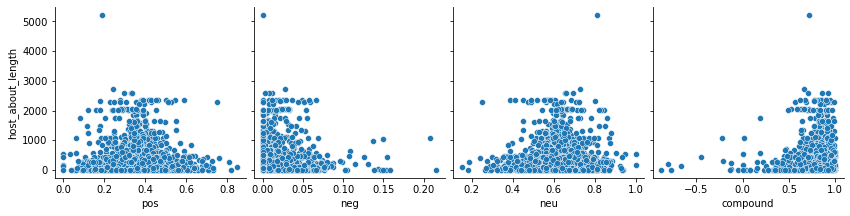

In [36]:
sns.pairplot(listing_reviews, 
             x_vars = ['pos', 'neg', 'neu', 'compound'], 
             y_vars = ['host_about_length'], 
             diag_kind = None, 
             height = 3);

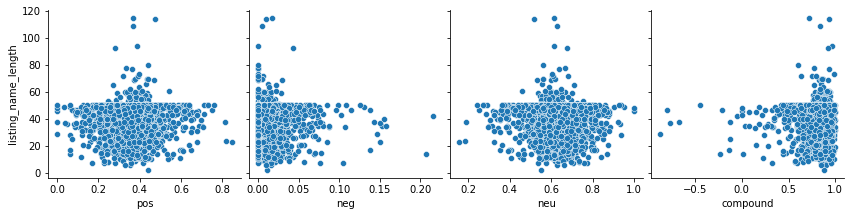

In [37]:
sns.pairplot(listing_reviews, 
             x_vars = ['pos', 'neg', 'neu', 'compound'], 
             y_vars = ['listing_name_length'], 
             diag_kind = None, 
             height = 3);

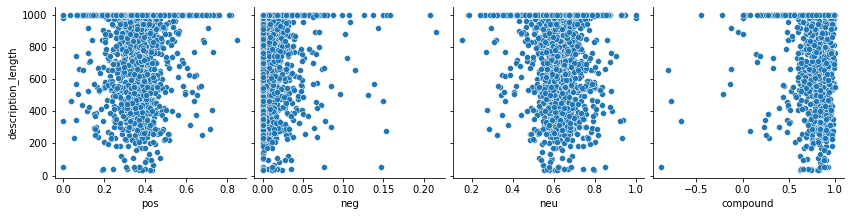

In [38]:
sns.pairplot(listing_reviews, 
             x_vars = ['pos', 'neg', 'neu', 'compound'], 
             y_vars = ['description_length'], 
             diag_kind = None, 
             height = 3);

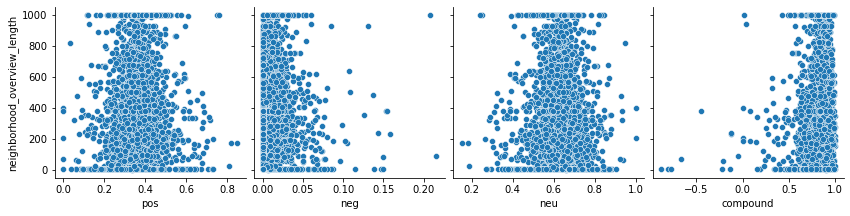

In [39]:
sns.pairplot(listing_reviews, 
             x_vars = ['pos', 'neg', 'neu', 'compound'], 
             y_vars = ['neighborhood_overview_length'], 
             diag_kind = None, 
             height = 3);

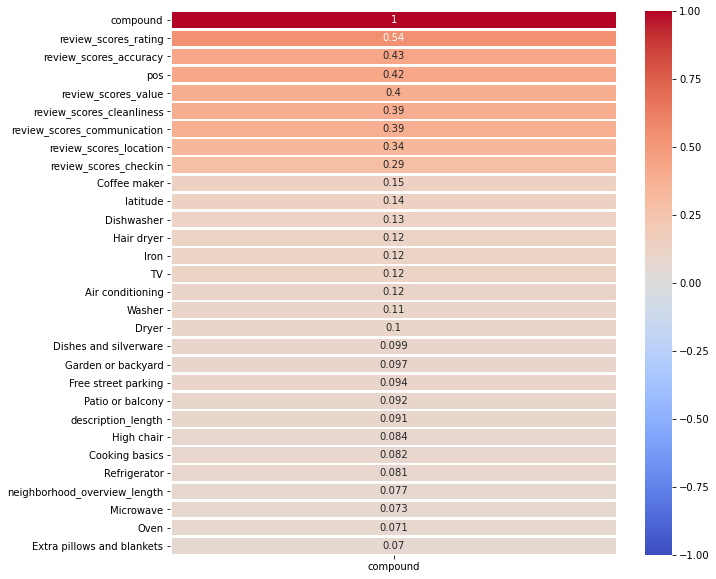

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing_reviews.corr()[['compound']].sort_values(by = ['compound'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

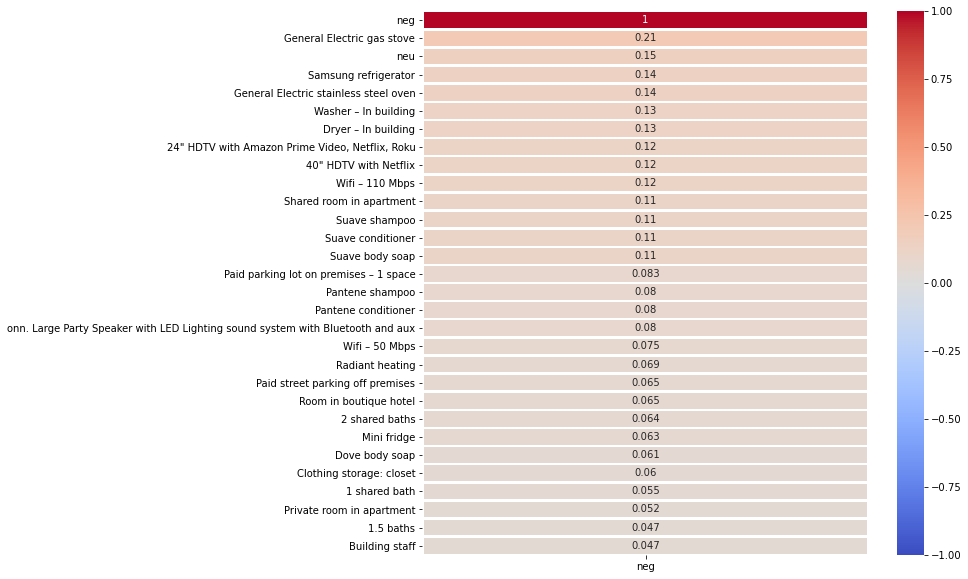

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing_reviews.corr()[['neg']].sort_values(by = ['neg'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

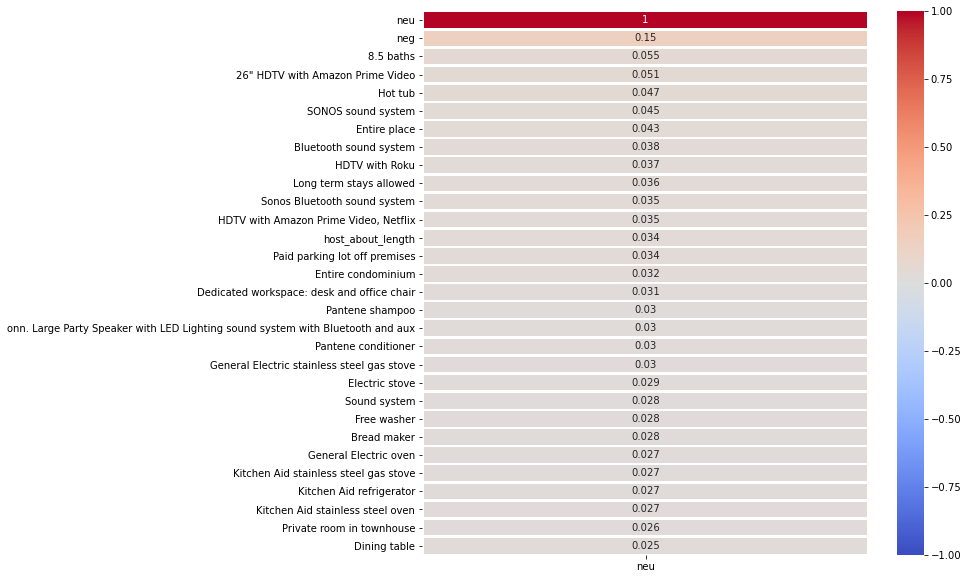

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing_reviews.corr()[['neu']].sort_values(by = ['neu'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

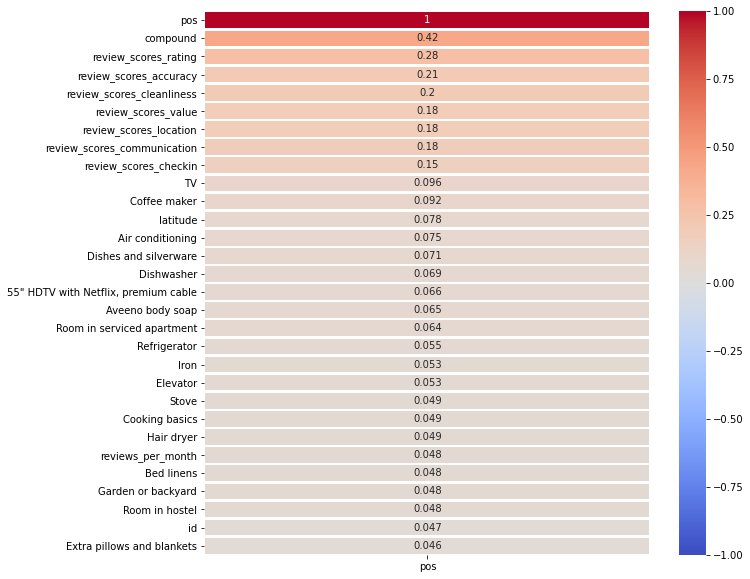

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing_reviews.corr()[['pos']].sort_values(by = ['pos'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

In [44]:
listing_reviews.sort_values(by = 'pos', ascending = False).head()

,id,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,"120"" HDTV with Netflix, Amazon Prime Video, HBO Max","24"" HDTV with Amazon Prime Video, Netflix, Roku","25"" HDTV with Netflix","26"" HDTV with Amazon Prime Video","30"" HDTV with standard cable","32"" HDTV","32"" HDTV with HBO Max, premium cable","33"" HDTV with Netflix, Amazon Prime Video, Chromecast","40"" HDTV","40"" HDTV with Netflix","40"" TV with Roku","42"" HDTV","42"" HDTV with Netflix, Amazon Prime Video","42"" HDTV with Roku","42"" HDTV with premium cable","42"" HDTV with standard cable, premium cable","43"" HDTV with Netflix, HBO Max, Amazon Prime Video","50"" HDTV with Amazon Prime Video, HBO Max, Netflix","50"" HDTV with Amazon Prime Video, Netflix, Roku","50"" HDTV with Amazon Prime Video, Netflix, standard cable","50"" HDTV with Netflix, Amazon Prime Video",...,Private room in hostel,Private room in house,Private room in loft,Private room in serviced apartment,Private room in tiny house,Private room in townhouse,Room in aparthotel,Room in bed and breakfast,Room in boutique hotel,Room in hostel,Room in hotel,Room in serviced apartment,Shared room in apartment,Shared room in bungalow,Shared room in condominium,Shared room in hostel,Shared room in house,Tiny house,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,11 shared baths,11.5 shared baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3 shared baths,3.5 baths,4 baths,4 shared baths,4.5 baths,5 baths,5.5 baths,6.5 baths,7 baths,8 shared baths,8.5 baths,Half-bath,Private half-bath,Shared half-bath,pos,neu,neg,compound
2979,36693814,Urban Oasis single room,"Three bedroom unit with two spare rooms. Perfect for quick trips to the city or music festivals. Quick travel times downtown, to Union Park, Douglas Park, Humboldt Park and the United Center.<br /...","Neighborhood has a full service grocery and some take away food spots, but not much else. 10-15 minute ride to fantastic areas like Wicker Park, Logan Square and River West.",2015-12-01,"Frequent traveler, often to tropical locales. I am a yogi, a writer and a builder of spaces.",within a few hours,57.384615,0.0,East Garfield Park,41.88259,-87.69225,2,1.0,100,2,4,1,2019-09-16,2019-09-16,100.0,10.0,10.0,10.0,10.0,8.0,10.0,0,0.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.846,0.154,0.0,0.9001
724,13148936,Webster Place by the zoo,"Our place is a 2 year old renovation! You'll love the kitchen, location, and the coziness. Perfect for couples, solo adventurers, and business travelers. <br /><br />The Victorian row house with t...","Lincoln Park and the Zoo is 2 blocks east and Oz Park is just 2 blacks west. Most of the area is ""down zoned"" so you will find single family homes and small apt. buildings.",2016-05-17,No Content,within a few hours,1.000000,1.0,Lincoln Park,41.92263,-87.64007,3,1.0,134,2,120,36,2016-06-22,2020-09-20,93.0,9.0,10.0,10.0,10.0,10.0,9.0,1,0.63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.817,0.183,0.0,0.9246
3297,39392454,"Chicago's NW CLEAN/Cozy Full SZ BR ""B""","Northwest Chicago Belmont/Portgage Basement 2 bedroom apartment coneveniently Located 20 minutes west of Wrigley Ville, 20 minutes NW from Down Town & 30 min NE from O'hare! Sleeps 2-8 people, per...",Belmont Central/Portgage park,2016-04-27,"We love traveling when we can, meeting new people, spending time with family and friends and

In [45]:
listing_reviews.sort_values(by = 'neg', ascending = False).head()

,id,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,"120"" HDTV with Netflix, Amazon Prime Video, HBO Max","24"" HDTV with Amazon Prime Video, Netflix, Roku","25"" HDTV with Netflix","26"" HDTV with Amazon Prime Video","30"" HDTV with standard cable","32"" HDTV","32"" HDTV with HBO Max, premium cable","33"" HDTV with Netflix, Amazon Prime Video, Chromecast","40"" HDTV","40"" HDTV with Netflix","40"" TV with Roku","42"" HDTV","42"" HDTV with Netflix, Amazon Prime Video","42"" HDTV with Roku","42"" HDTV with premium cable","42"" HDTV with standard cable, premium cable","43"" HDTV with Netflix, HBO Max, Amazon Prime Video","50"" HDTV with Amazon Prime Video, HBO Max, Netflix","50"" HDTV with Amazon Prime Video, Netflix, Roku","50"" HDTV with Amazon Prime Video, Netflix, standard cable","50"" HDTV with Netflix, Amazon Prime Video",...,Private room in hostel,Private room in house,Private room in loft,Private room in serviced apartment,Private room in tiny house,Private room in townhouse,Room in aparthotel,Room in bed and breakfast,Room in boutique hotel,Room in hostel,Room in hotel,Room in serviced apartment,Shared room in apartment,Shared room in bungalow,Shared room in condominium,Shared room in hostel,Shared room in house,Tiny house,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,11 shared baths,11.5 shared baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3 shared baths,3.5 baths,4 baths,4 shared baths,4.5 baths,5 baths,5.5 baths,6.5 baths,7 baths,8 shared baths,8.5 baths,Half-bath,Private half-bath,Shared half-bath,pos,neu,neg,compound
1661,24162662,1、《home in Chicago》2 bedroom 1 living room,"There is have two rooms ，near restaurants, schools, supermarkets, buses, subway stations, new and refined decoration, unlimited network, easy parking , one free parking on back door ，spaces. Phone...","Nearby are Mexican restaurants, barber shops, nail shops, supermarkets, 99 hair shops, etc.",2018-04-01,No Content,within a few hours,57.384615,2.0,Brighton Park,41.81678,-87.69831,4,2.0,69,2,30,60,2018-04-06,2019-03-22,87.0,9.0,9.0,9.0,9.0,8.0,9.0,0,1.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.217000,0.567333,0.215667,-0.052600
373,6768827,Space of Grace,"This Room is snuggled in the center of Bronzeville/Hyde Park area, rich in amazing history, greatest & most culturally diverse neighborhoods in Chicago, just blocks from McCormick place, Wintrust ...","I love the diversity of this Ahh-mazing historical district, and plus the Chicago Street Art. You will experience quiet comforts of a home like setting. The Bronzeville Hyde Park area, rich in am...",2012-10-30,"The Elect Lady Grayer is the Founder of the Works of Elohim International Inc. She is the Director of the Omega Mansion/Bronzeville, an Entrepreneur and Author of Books: ""Don't Shoot - I'm Alread...",within a few hours,57.384615,6.0,Grand Boulevard,41.81833,-87.61304,1,1.0,96,27,28,11,2015-07-13,2019-06-03,95.0,10.0,10.0,10.0,9.0,9.0,9.0,0,0.16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.215000,0.577500,0.207500,0.014050
3403,40633552,Magmile Hotel 2 Beds Prime Location,"21 and Older. Walk to renowned attractions, enjoy the lakefront, and return to this comfortable room with 255 square feet of space, two double beds, modern furnishings, and indulgent linens and b...","Excellent Location Steps to World Famous Magnificent Mile Shoppin

In [46]:
listing_reviews.sort_values(by = 'compound', ascending = False).head()

,id,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,"120"" HDTV with Netflix, Amazon Prime Video, HBO Max","24"" HDTV with Amazon Prime Video, Netflix, Roku","25"" HDTV with Netflix","26"" HDTV with Amazon Prime Video","30"" HDTV with standard cable","32"" HDTV","32"" HDTV with HBO Max, premium cable","33"" HDTV with Netflix, Amazon Prime Video, Chromecast","40"" HDTV","40"" HDTV with Netflix","40"" TV with Roku","42"" HDTV","42"" HDTV with Netflix, Amazon Prime Video","42"" HDTV with Roku","42"" HDTV with premium cable","42"" HDTV with standard cable, premium cable","43"" HDTV with Netflix, HBO Max, Amazon Prime Video","50"" HDTV with Amazon Prime Video, HBO Max, Netflix","50"" HDTV with Amazon Prime Video, Netflix, Roku","50"" HDTV with Amazon Prime Video, Netflix, standard cable","50"" HDTV with Netflix, Amazon Prime Video",...,Private room in hostel,Private room in house,Private room in loft,Private room in serviced apartment,Private room in tiny house,Private room in townhouse,Room in aparthotel,Room in bed and breakfast,Room in boutique hotel,Room in hostel,Room in hotel,Room in serviced apartment,Shared room in apartment,Shared room in bungalow,Shared room in condominium,Shared room in hostel,Shared room in house,Tiny house,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,11 shared baths,11.5 shared baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3 shared baths,3.5 baths,4 baths,4 shared baths,4.5 baths,5 baths,5.5 baths,6.5 baths,7 baths,8 shared baths,8.5 baths,Half-bath,Private half-bath,Shared half-bath,pos,neu,neg,compound
494,8459072,Happy home to share,"Hello! Our house is 2.5 blocks from the EL (train) & bike rentals. Close to Lagunitas Brewing Company, and next to Douglas Park. You’ll love our recently remodeled living areas, yoga/workout space...",North Lawndale is a really special place with a ton of history. It's centrally located so all parts of Chicago are easily accessible. We are located within a block of one of Chicago's largest park...,2015-09-18,"I'm a designer for a college study abroad program and my husband, Brian, is a dog walker. We've lived in Chicago for over 10 years and love our city. Chicago is such a diverse place, each neighbor...",within a few hours,57.384615,1.0,North Lawndale,41.85809,-87.70352,5,3.0,60,1,10,29,2017-01-14,2019-09-15,99.0,10.0,10.0,10.0,10.0,9.0,10.0,1,0.58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.279,0.712,0.009,0.9972
813,14431243,"Spacious Queen Room w/Desk, TV, Bathroom &Home Gym","GREAT WORK-FROM-HOME SPACE! Enjoy your own PRIVATE room with large desk & lamp, queen size bed with deluxe Sleep Science mattress, Smart TV, and spacious in-room closet, in this spectacularly reha...","The condo is located in the midst of Lakeview and within walking distance (2-3 blocks) of : Boystown, Wrigleyville, Southport Corridor and only 10 blocks from Lincoln Park. The Lakeshore is a sho...",2010-08-22,"I have lived in Chicago since August 2011 and am in love with all the sights, sounds, vibrancy, nature, outdoor activities, and culinary options this beautiful city has to offer. Prior to Chicago...",within an hour,0.980000,5.0,Lake View,41.94525,-87.65709,1,1.0,67,10,45,64,2016-08-15,2020-02-13,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.210,0.782,0.008,0.9966
317,6112891,Furnished Gold Coast

## TF-IDF

Splitting up the dataframe into 3 separate dataframes in order to be able to see what words are popping up in negative reviews, positive reviews, and neutral reviews.

In [47]:
reviews_neu = reviews[(reviews['neu'] == 1.000) | (reviews['neg'] == reviews['pos'])]
reviews_pos = reviews[reviews['pos'] > reviews['neg']]
reviews_neg = reviews[reviews['neg'] > reviews['pos']]


print(f'Neutral Reviews: {reviews_neu.shape}')
print(f'Positive Reviews: {reviews_pos.shape}')
print(f'Negative Reviews: {reviews_neg.shape}')

Neutral Reviews: (623, 6)
Positive Reviews: (58781, 6)
Negative Reviews: (799, 6)


Adding stop words that proved to be frequent words but showed no value.

In [48]:
words = ['chicago', 'didn', 'definitely', 'check', 'bnb', 'air', 've', 'did', 'needed', 'nice', 
         'red', 'blue', 'line', 'was', 'wa', 'airbnb', 'minute', 'train', 'place', 'stay', 'great', 'space',
         'apartment', 'super', 'home']

stop_words = text.ENGLISH_STOP_WORDS.union(words)

In [49]:
tvec = TfidfVectorizer(stop_words = stop_words, max_features = 4000)

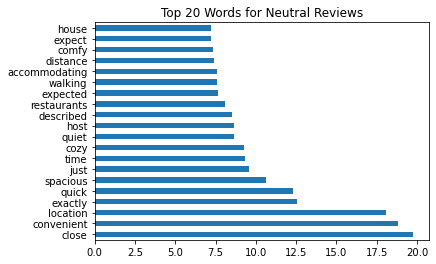

In [50]:
X_tvec_neu = tvec.fit_transform(reviews_neu['comment'])

df_X_neu = pd.DataFrame(X_tvec_neu.todense(), columns = tvec.get_feature_names())

df_X_neu.sum().sort_values(ascending = False).head(20).plot(kind ='barh')
plt.title('Top 20 Words for Neutral Reviews');

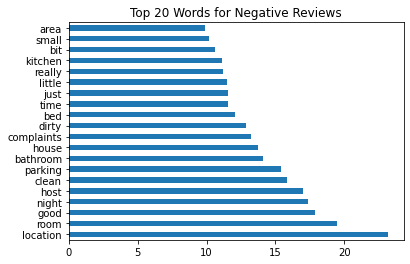

In [51]:
X_tvec_neg = tvec.fit_transform(reviews_neg['comment'])

df_X_neg = pd.DataFrame(X_tvec_neg.todense(), columns = tvec.get_feature_names())

df_X_neg.sum().sort_values(ascending = False).head(20).plot(kind ='barh')
plt.title('Top 20 Words for Negative Reviews');

In [52]:
tvec = TfidfVectorizer(stop_words = stop_words, max_features = 4000, min_df = 0.001)

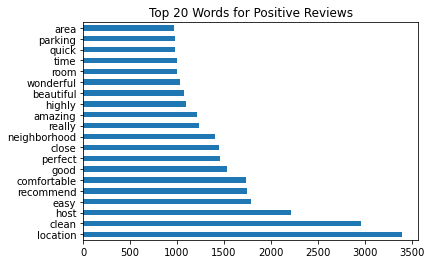

In [53]:
X_tvec_pos = tvec.fit_transform(reviews_pos['comment'])

df_X_pos = pd.DataFrame(X_tvec_pos.todense(), columns = tvec.get_feature_names())

df_X_pos.sum().sort_values(ascending = False).head(20).plot(kind ='barh')
plt.title('Top 20 Words for Positive Reviews');

#### Bigrams

In [54]:
tvec_2 = TfidfVectorizer(stop_words = stop_words, ngram_range = (2,2))

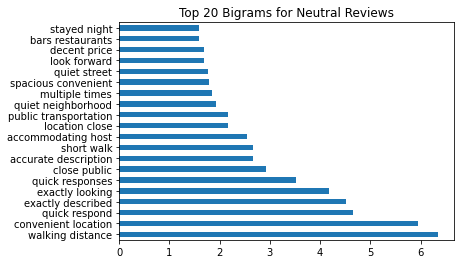

In [55]:
X_2_tvec_neu = tvec_2.fit_transform(reviews_neu['comment'])

df_X_2_neu = pd.DataFrame(X_2_tvec_neu.todense(), columns = tvec_2.get_feature_names())

df_X_2_neu.sum().sort_values(ascending = False).head(20).plot(kind='barh')
plt.title('Top 20 Bigrams for Neutral Reviews');

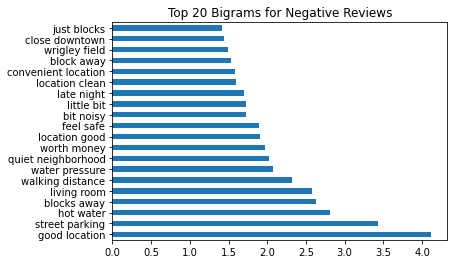

In [56]:
X_2_tvec_neg = tvec_2.fit_transform(reviews_neg['comment'])

df_X_2_neg = pd.DataFrame(X_2_tvec_neg.todense(), columns = tvec_2.get_feature_names())

df_X_2_neg.sum().sort_values(ascending = False).head(20).plot(kind ='barh')
plt.title('Top 20 Bigrams for Negative Reviews');

In [57]:
tvec_2_pos = TfidfVectorizer(stop_words = stop_words, ngram_range = (2,2), min_df = 0.001)

In [58]:
X_2_tvec_pos = tvec_2_pos.fit_transform(reviews_pos['comment'])

In [59]:
df_X_2_pos = pd.DataFrame(X_2_tvec_pos.todense(), columns = tvec_2_pos.get_feature_names())

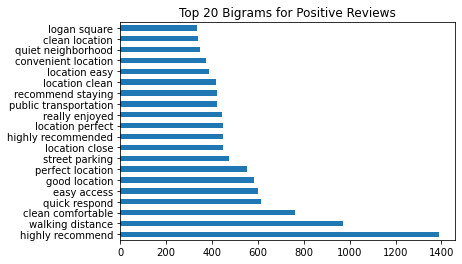

In [60]:
df_X_2_pos.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')
plt.title('Top 20 Bigrams for Positive Reviews');

## Pre-Processing

Tokenizing the text, which splits it into individual words, removes punctuation and adjusts all letters to be lowercase. Then lemmatizing the words, which changes words in third person to first person and verbs in past and future tenses into present tense. With tokenizing and lemmatizing, the words are returned to their base/dictionary form.

In [61]:
reviews['review_tokens'] = reviews.apply(lambda row: word_tokenize(row['comment']), axis = 1)

In [62]:
def lemmatize_text(review):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in review]

reviews['review_lemmatized'] = reviews['review_tokens'].apply(lemmatize_text)
reviews['review_lemmatized'] = reviews['review_lemmatized'].str.join(' ')

In [63]:
tvec = TfidfVectorizer(stop_words = stop_words, min_df = 0.001, ngram_range = (1,2))

tvec_reviews = tvec.fit_transform(reviews['review_lemmatized'])    #Sparce Matrix

In [64]:
tvec_t = tvec_reviews.transpose() # transpose document-term matrix -> to convert it to a term-document matrix

# # Convert to Gensim Corpus
# #     Gensim requires the format of the input to be a Gensim corpus data type

sparse = scipy.sparse.csr_matrix(tvec_t)

corpus = matutils.Sparse2Corpus(tvec_t)

In [65]:
dictionary = dict((v,k) for k,v in tvec.vocabulary_.items())

gensim_dict = Dictionary.from_corpus(corpus = corpus, id2word = dictionary)

## Topic Modeling

In [66]:
lda = LdaModel(corpus = corpus, 
               num_topics = 5, 
               id2word = dictionary, 
               passes = 60, 
               decay = 0.8,           
               offset = 10,           
               random_state = 49)

In [67]:
coherence = CoherenceModel(model = lda,
                           corpus = corpus,
                           dictionary = dictionary,
                           coherence = 'u_mass')       

print(round(coherence.get_coherence(), 3))

-2.576


In [68]:
prep = pyLDAvis.gensim.prepare(lda, corpus, gensim_dict)

pyLDAvis.display(prep)

In [69]:
lda.print_topics(num_topics = 10, num_words = 12)

[(0,
  '0.017*"perfect" + 0.012*"time" + 0.010*"amazing" + 0.010*"loved" + 0.010*"location" + 0.008*"recommend" + 0.008*"staying" + 0.007*"best" + 0.007*"host" + 0.007*"experience" + 0.007*"weekend" + 0.007*"like"'),
 (1,
  '0.037*"location" + 0.033*"clean" + 0.024*"good" + 0.023*"easy" + 0.015*"value" + 0.015*"convenient" + 0.015*"communication" + 0.014*"comfortable" + 0.014*"excellent" + 0.013*"host" + 0.012*"good location" + 0.010*"parking"'),
 (2,
  '0.010*"room" + 0.009*"bed" + 0.007*"parking" + 0.007*"kitchen" + 0.006*"clean" + 0.006*"good" + 0.006*"bathroom" + 0.006*"night" + 0.006*"comfortable" + 0.005*"house" + 0.005*"bedroom" + 0.005*"bit"'),
 (3,
  '0.023*"close" + 0.016*"restaurant" + 0.013*"neighborhood" + 0.013*"downtown" + 0.012*"easy" + 0.012*"walking" + 0.012*"distance" + 0.011*"walk" + 0.011*"location" + 0.011*"walking distance" + 0.010*"quiet" + 0.008*"clean"'),
 (4,
  '0.036*"host" + 0.020*"recommend" + 0.019*"highly" + 0.017*"quick" + 0.015*"clean" + 0.015*"locatio